In [0]:
we
!pip install mtcnn



!mkdir train
!mkdir train/nick
!mkdir train/ibah
!mkdir val
!mkdir val/nick
!mkdir val/ibah

     |████████████████████████████████| 2.3MB 5.1MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257692 sha256=98cb091d738ab9b92d7a5f021ace02c9566e5d7e84978e98a9a891a6201e7a08
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


In [0]:
!rm -r train
!rm -r val

In [0]:
!wget https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5

--2019-08-08 13:33:22--  https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/satinder147/Attendance-using-Face/master/facenet_keras.h5 [following]
--2019-08-08 13:33:22--  https://raw.githubusercontent.com/satinder147/Attendance-using-Face/master/facenet_keras.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92397640 (88M) [application/octet-stream]
Saving to: ‘facenet_keras.h5’

facenet_keras.h5    100%[===================>]  88.12M   173MB/s    in 0.5s    

2019-08-08 13:33:24 (173 MB/s) - ‘facenet_keras.h5’ saved [92397

In [2]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import mtcnn

In [4]:

# demonstrate face detection on 5 Celebrity Faces Dataset
import os
from os import listdir
from PIL import Image
from numpy import asarray,savez_compressed
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not os.path.isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)


trainX, trainy = load_dataset('train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('nick+ibah.npz', trainX, trainy, testX, testy)

>loaded 7 examples for class: ibah
>loaded 9 examples for class: nick
(16, 160, 160, 3) (16,)
>loaded 3 examples for class: ibah
>loaded 4 examples for class: nick
(7, 160, 160, 3) (7,)


In [5]:
data = load('nick+ibah.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (16, 160, 160, 3) (16,) (7, 160, 160, 3) (7,)


In [6]:
from keras.models import load_model
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded Model


/home/mykola/.local/lib/python3.6/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('nick+ibah2.npz', newTrainX, trainy, newTestX, testy)

(16, 128)
(7, 128)


In [8]:
# load dataset
data = load('nick+ibah2.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(trainy)
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

model_final = SVC(kernel='linear')
model_final.fit(trainX, trainy)

['ibah' 'ibah' 'ibah' 'ibah' 'ibah' 'ibah' 'ibah' 'nick' 'nick' 'nick'
 'nick' 'nick' 'nick' 'nick' 'nick' 'nick']
Dataset: train=16, test=7


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [9]:
trainX[0]

array([-0.04040077,  0.09412887, -0.18600535,  0.07499978,  0.02501716,
       -0.12971847,  0.03989355, -0.14321513,  0.03259544, -0.06665657,
       -0.05579572, -0.02101262, -0.00529321, -0.04871218,  0.08846527,
        0.01581049,  0.03481034,  0.08232957, -0.0851592 , -0.03006044,
        0.05074221, -0.06465843, -0.01525548, -0.01338047,  0.12925142,
       -0.09700902,  0.12966897,  0.05244962, -0.02606807, -0.05559457,
       -0.0256939 ,  0.02709699, -0.05761924,  0.08155216,  0.00752544,
       -0.02416809, -0.1111404 , -0.14584444, -0.06444936, -0.04469066,
       -0.03465591,  0.04225505,  0.07662901,  0.06315283,  0.05593704,
       -0.08906994,  0.09121753, -0.07119189, -0.02519017,  0.02307595,
       -0.12804769,  0.030589  , -0.070108  ,  0.15693285,  0.06669202,
       -0.01046097, -0.11403598,  0.07568143, -0.14769506,  0.01717375,
        0.02720208, -0.04547787,  0.09616245, -0.01116195,  0.06843123,
        0.10265003, -0.10004038,  0.1421737 ,  0.06471012, -0.08

In [10]:
yhat_train = model_final.predict(trainX)
yhat_test = model_final.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


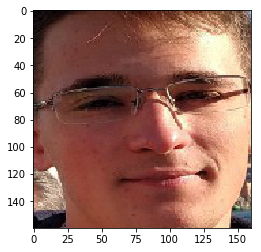

nick


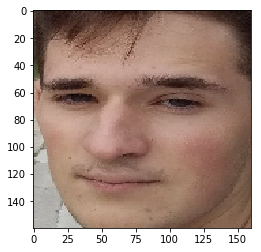

nick


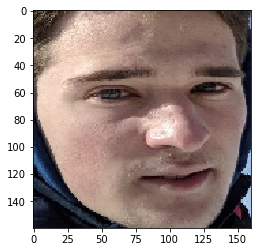

nick


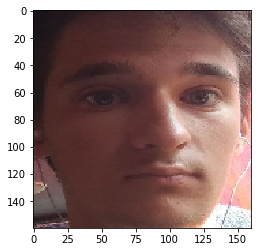

nick


In [11]:
for img_path in listdir('val/nick/'):

# img_name = 'photo5931367823555276999.jpg'

  imgs = asarray(extract_face('val/nick/' + img_path))
  plt.imshow(imgs)
  plt.show()

  emb = get_embedding(model, imgs)
  emb = asarray([emb])
  lab = model_final.predict(emb)
  print(out_encoder.inverse_transform(lab)[0])

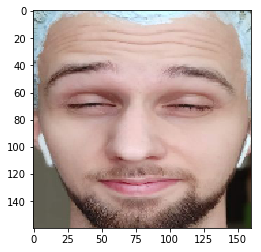

ibah


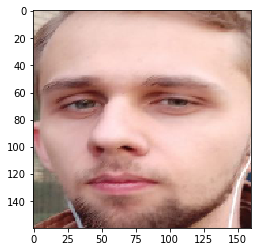

ibah


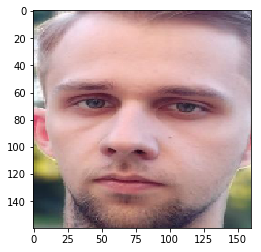

ibah


In [0]:
for img_path in listdir('val/ibah/'):

# img_name = 'photo5931367823555276999.jpg'

  imgs = asarray(extract_face('val/ibah/' + img_path))
  plt.imshow(imgs)
  plt.show()

  emb = get_embedding(model, imgs)
  emb = asarray([emb])
  lab = model_final.predict(emb)
  print(out_encoder.inverse_transform(lab)[0])

In [12]:
def extract_img(array, required_size=(160, 160)):
	# load image from file
	image = Image.fromarray(array)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [ ]:
import numpy as np
import cv2
from mtcnn.mtcnn import MTCNN

# multiple cascades: https://github.com/Itseez/opencv/tree/master/data/haarcascades

#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haar.xml')
#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

cap = cv2.VideoCapture(0)
detector = MTCNN()


while 1:
    ret, img = cap.read()
    img_pil = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(img_pil)

    for i in range(len(result)):
        # Result is an array with all the bounding boxes detected. We know that for 'ivan.jpg' there is only one.
        bounding_box = result[i]['box']
        keypoints = result[i]['keypoints']
        
        frame = img_pil[bounding_box[0]-50:bounding_box[0]+bounding_box[2] + 51,bounding_box[1] - 50:bounding_box[1]+bounding_box[3] + 51]
        

        imgs = asarray(extract_img(frame))
        emb = get_embedding(model, imgs)
        emb = asarray([emb])
        lab = model_final.predict(emb)
        cv2.putText(img, out_encoder.inverse_transform(lab)[0],(bounding_box[0], bounding_box[1]),4,(255,255,255),2,cv2.LINE_AA)
        cv2.rectangle(img,
                        (bounding_box[0], bounding_box[1]),
                        (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                        (0,155,255),
                        2)

#         cv2.circle(img,(keypoints['left_eye']), 2, (0,155,255), 2)
#         cv2.circle(img,(keypoints['right_eye']), 2, (0,155,255), 2)
#         cv2.circle(img,(keypoints['nose']), 2, (0,155,255), 2)
#         cv2.circle(img,(keypoints['mouth_left']), 2, (0,155,255), 2)
#         cv2.circle(img,(keypoints['mouth_right']), 2, (0,155,255), 2)

    cv2.imshow('img',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()
